In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torchvision
from torchvision import transforms
from scipy import fft
import math

# Download the EMNIST dataset

In [2]:
trainset = torchvision.datasets.EMNIST(root = './data', split = 'letters', 
                                       train = True, download = True, 
                                       transform = transforms.ToTensor()
                                      )

2.0%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

2.7%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

5.2%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

6.1%IOPub mes

Extracting ./data\EMNIST\raw\emnist.zip to ./data\EMNIST\raw
Processing byclass


C:\Users\Taewoong\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datasets\mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Processing bymerge
Processing balanced
Processing letters
Processing digits
Processing mnist
Done!


In [3]:
train_X_wide = trainset.data.numpy()
train_Y_int = trainset.targets.numpy()

In [4]:
for i in range(124800):
    train_X_wide[i] = np.transpose(train_X_wide[i])

# Chop two pixels off the boundary of the image to make Sigma_xx full rank

In [5]:
train_X_cut = np.reshape(train_X_wide[:,2:26,2:26],(-1,24,24))

# Processing the data

In [6]:
### Let train_X be a 124800 x 576 matrix. Each row of train_X is the flattened matrix representing each image 
### transpose train_X at the end to make it a 576 x 124800 matrix

train_X = np.ndarray(shape=(124800, 24*24))
for i in range(124800):
    train_X[i] = train_X_cut[i].flatten()
        
train_X = np.transpose(train_X)

(576, 124800)

In [7]:
### Let train_Y be a 124800 x 26 matrix. Each row of train_Y is a one-hot vector representing the image label 0 through 9
### If the image label is 0, the one hot representation will be [1,0,0,...,0]. 
### If label is 1, the one hot vector will be [0,1,0,0,...,0] and so on.

train_Y = np.zeros(shape = (124800, 26))
for i in range(124800):
    train_Y[i][train_Y_int[i]-1] = 10000

train_Y = np.transpose(train_Y)

(26, 124800)

# Full Batch Sigma_xx & Sigma_yx, W_optimal

In [8]:
### Calculate sigma_xx, sigma_yx for the full dataset

sigma_xx_full = np.zeros((576, 576))
sigma_yx_full = np.zeros((26, 576))

for i in range(124800):
    x = train_X[:,i].reshape((576,1))
    y = train_Y[:,i].reshape((26,1))
    sigma_xx_full += x * x.T
    sigma_yx_full += y * x.T
    
sigma_xx_full = sigma_xx_full / 124800
sigma_yx_full = sigma_yx_full / 124800

In [9]:
sigma_xx_inv = np.linalg.inv(sigma_xx_full)

In [10]:
W_optimal = np.matmul(sigma_yx_full, sigma_xx_inv)

# Define Error

In [11]:
def getCosError(W1, W2):
    ### returns (1-cosine) value of the angle between two "vectors" W1 and W2
    return 1.0-(np.sum(np.multiply(W1, W2)) / (np.linalg.norm(W1) * np.linalg.norm(W2)))

# Mini Batch Gradient Descent

In [12]:
### randomly select a minibatch and compute sigma_xx, sigma_yx
def generate_minibatch(batch_size):
    sample = random.sample(range(124800), batch_size)
    x_minibatch = train_X[:,sample]
    y_minibatch = train_Y[:,sample]
    
    sigma_xx = np.zeros((576, 576))
    sigma_yx = np.zeros((26, 576))
    for i in range(batch_size):
        x = x_minibatch[:,i].reshape((576,1))
        y = y_minibatch[:,i].reshape((26,1))
        sigma_xx += x * x.T
        sigma_yx += y * x.T
        
    sigma_xx = sigma_xx / batch_size
    sigma_yx = sigma_yx / batch_size
    return (sigma_xx, sigma_yx)

In [13]:
#randomly initialize W
W = W_optimal + 0.5 * np.random.randn(26, 576)

In [14]:
max_epochs = 800000
converging_range = 20000

learning_rate = 0.0000002
error_list = []

###list to save W's and sigma_yx's for later analysis
W_list=[]
sigma_yx_list=[]

for epoch in range(0, max_epochs + 1):
    ###calculating error for every 100th epoch to reduce running time
    if epoch % 100 == 0:
      error_list.append(getCosError(W, W_optimal))
    
    #generating minibatch
    (mb_sigma_xx,mb_sigma_yx)=generate_minibatch(100)
    
    #saving W's and sigma_yz's only in converging range
    if epoch > max_epochs - converging_range:
        W_list.append(W)
        sigma_yx_list.append(mb_sigma_yx)
    
    #gradient descent
    W = W + learning_rate*np.matmul(-W, mb_sigma_xx) + learning_rate*mb_sigma_yx

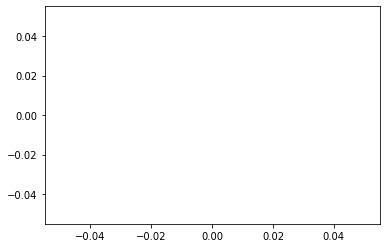

In [15]:
#plotting error list to see convergence
plt.plot(error_list[1:])

# Defining Sigma WW, D, and SigmaXXSigmaWW+SigmaWWSigmaXX

In [16]:
sigma_WW=np.zeros((576,576))
D=np.zeros((576,576))
interval_length=len(W_list)

for n in range(interval_length):
    W = W_list[n] - W_optimal
    sigma_WW += np.matmul(W.T,W)
    sigma_yx = sigma_yx_list[n] - sigma_yx_full
    D += np.matmul(sigma_yx.T,sigma_yx)
    
sigma_WW/=interval_length
D/=interval_length
sigma_XXWW = np.matmul(sigma_xx_full,sigma_WW)+np.matmul(sigma_WW,sigma_xx_full)

# Matrix Contour Plots

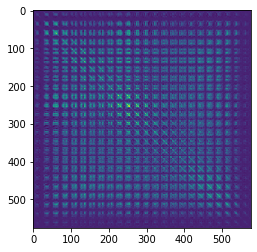

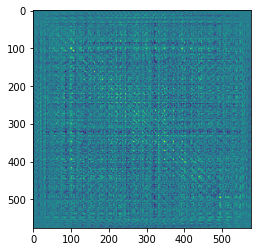

In [17]:
#Contour plot of D
plt.imshow(D, interpolation = 'nearest')
plt.show()
#Contour plot of SigmaXXSigmaWW+SigmaWWSigmaXX
plt.imshow(sigma_XXWW, interpolation = 'nearest')
plt.show()

# FFT Analysis of D and SigmaXXSigmaWW+SigmaWWSigmaXX

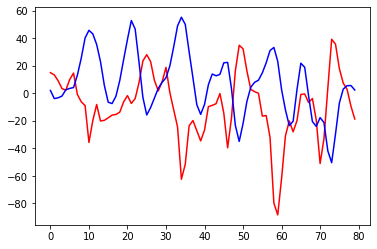

In [18]:
DPI = 200
output_range = 500
brightness_adjusting_factor = 1

def to_image(complex_input):
     output = np.abs(complex_input)**(1/brightness_adjusting_factor)
     return output

def plott(im, title=""):
    if (type(im[0,0]) == np.complex128):
        im = to_image(im)
    fig = plt.figure(dpi=DPI)
    plt.matshow(im)
    plt.title(title)
    
n = 0
X = []
Y = []

a=20
b=100
for i in range(a,b): #First row of FFT of D
     x = D[0][i]
     X.append(x)
for i in range(a,b): #First row of FFT of sigma_XXWW
     y = sigma_XXWW[0][i]
     Y.append(y)
t = np.arange(a,b,1)

plt.figure(1)
plt.plot(X/D[0][0],'r');
plt.plot(Y/sigma_XXWW[0][0],'b')
plt.show()

# Q Analysis

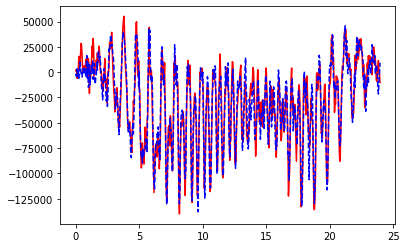

0.7817814524140684
0.9423936437080578


In [19]:
A = np.matmul(sigma_WW,sigma_xx_full) + np.matmul(sigma_xx_full, sigma_WW) # D matrix
B = np.matmul(sigma_WW,sigma_xx_full) - np.matmul(sigma_xx_full, sigma_WW) # Q matrix

x = 0
y = 0

X = []
Y = []

## graphing 10th row of D and Q matrices
for i in range(0, 576):
     x = A[10][i]
     X.append(x)
for i in range(0, 576):
     y = B[10][i]
     Y.append(y)

t = np.arange(0, 576,1)
plt.figure(1)
plt.plot(t/24, X,'r')
plt.plot(t/24, Y,'b--')
plt.show()

print(abs(B).max()/abs(A).max()) # Comparing maximum value of D and Q matrices
print(abs(B).sum() / abs(A).sum()) # Comparing sum of absolute value of D and Q matrices' elements

# FFT Analysis of Q

<Figure size 432x288 with 0 Axes>

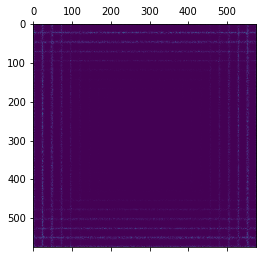

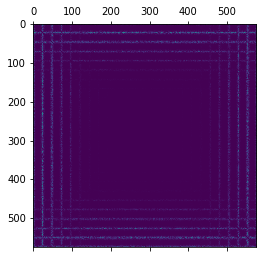

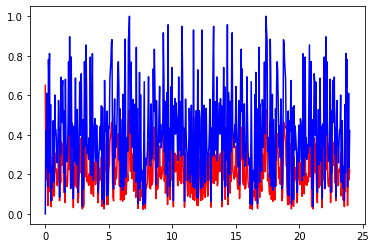

In [20]:
A_fft = np.abs(fft.fft2(A)) # FFT of D matrix and absolute braket for plotting
B_fft = np.abs(fft.fft2(B)) # FFT of Q matrix and absolute braket for plotting

plt.figure(1)
plt.matshow(A_fft)
plt.figure(2)
plt.matshow(B_fft)
plt.show()

E = []
G = []
for i in range(0, 576):
     e = A_fft[0][i]/(A_fft.max()) # first row of normalised FFT of D
     E.append(e)
for i in range(0, 576):
     g = B_fft[0][i]/(B_fft.max()) # first row of normalised FFT of Q
     G.append(g)
t = np.arange(0, 576,1)

plt.figure(1)
plt.plot(t/24, E,'r')
plt.plot(t/24, G,'b')

plt.show()